### Test notebook for OD experiments


In [3]:
# Perform imports
import torch
import numpy as np
from torchvision.models import detection
from torchvision.datasets import CocoDetection
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
import signal
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
import os
# from src.evaluators.pascal_voc_evaluator import get_pascalvoc_metrics
# from src.utils.enumerators import MethodAveragePrecision

# Global config
%load_ext line_profiler

plt.rcParams['figure.figsize'] = (20, 10)


In [4]:
# determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

COCO_LABELS = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'street sign',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'hat',
    'backpack',
    'umbrella',
    'shoe',
    'eye glasses',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'plate',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'mirror',
    'dining table',
    'window',
    'desk',
    'toilet',
    'door',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'blender',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush',
    'hair brush',
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_LABELS), 3))

LABEL_DICT = {
    'car': 'vehicle',
    'bus': 'vehicle',
    'truck': 'vehicle',
    'caravan': 'vehicle',
    'trailer': 'vehicle',
    'motorcycle': 'vehicle',
    'train': 'vehicle',
    'bicycle': 'vehicle',
    'person': 'pedestrian',
    'rider': 'pedestrian',
}

# Use pretrained model frcnn-mobilenet
model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True,
                                                        num_classes=len(COCO_LABELS), pretrained_backbone=True).to(DEVICE)
model.eval()


Running on cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

### Test model with a single image


In [3]:
def preprocess(image):
    image = image.transpose((2, 0, 1))

    # Reformat image data
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = torch.FloatTensor(image)
    image = torch.squeeze(image, 0)

    # Move data to correct device
    return image.to(DEVICE, non_blocking=True)


def draw_detections(image, detections, tol):
    # Loop over detections
    for i in range(0, len(detections["boxes"])):
        score = detections["scores"][i]

        # Ignore any detections below the tolerance
        if score > tol:
            # Pull important data
            idx = int(detections["labels"][i])
            box = detections["boxes"][i].detach().cpu().numpy()
            (x0, y0, x1, y1) = box.astype("int")
            label = "{}: {:.2f}%".format(COCO_LABELS[idx], score * 100)

            # draw the bounding box and label on the image
            cv2.rectangle(image, (x0, y0), (x1, y1),
                          COLORS[idx], 2)
            y = y0 - 15 if y0 - 15 > 15 else y0 + 15
            cv2.putText(image, label, (x0, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    return image


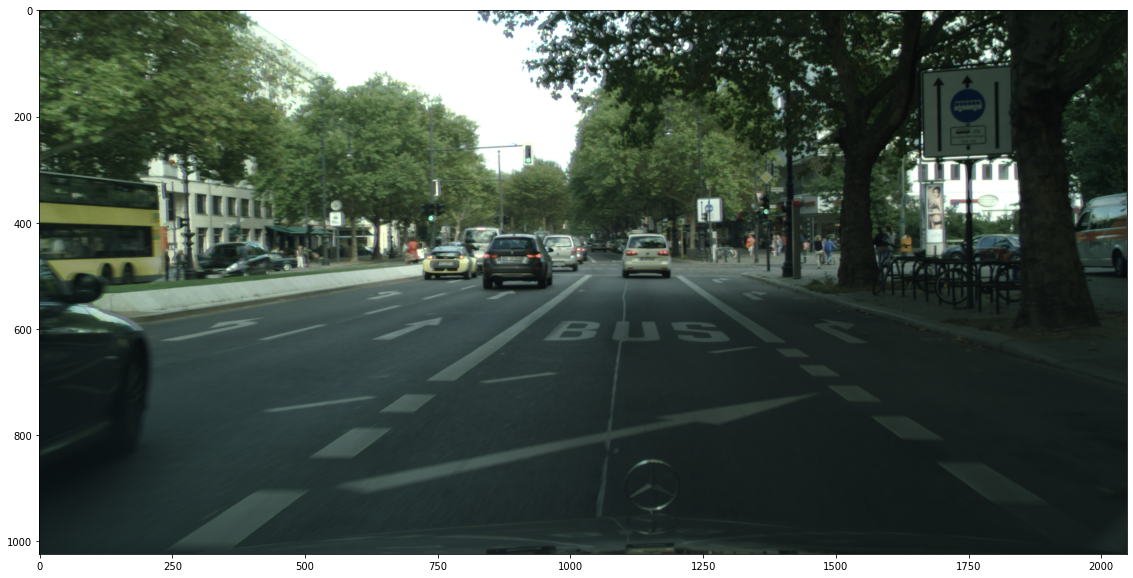

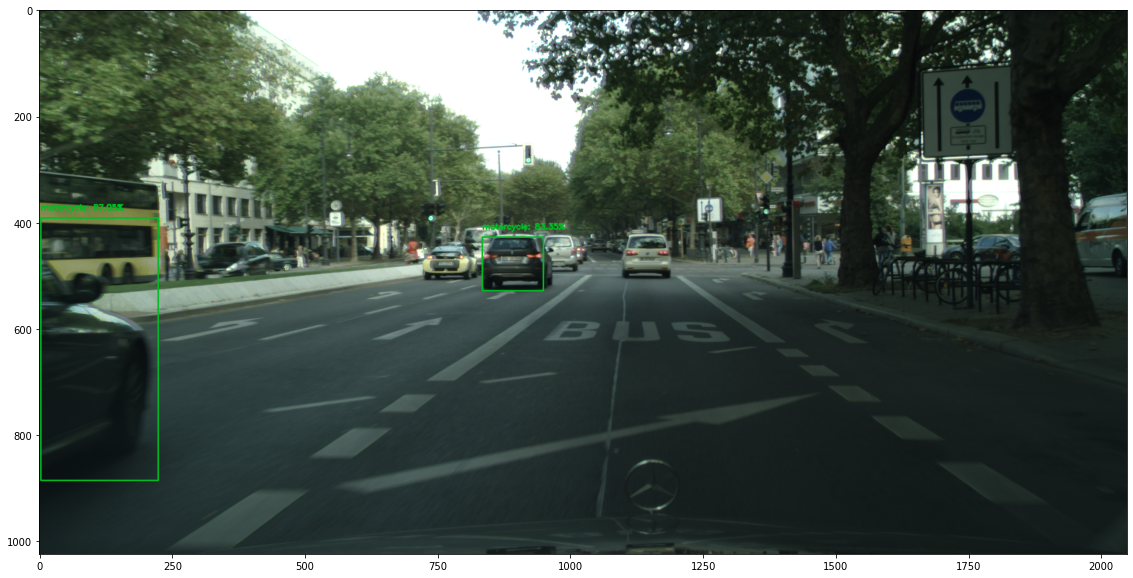

In [4]:
# Load test image
image = cv2.imread(
    "data/datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orig = image.copy()

plt.imshow(image)
plt.show()


image = preprocess(image)
result = model([image])

detections = result[0]

box_image = draw_detections(orig, detections, 0.8)

plt.imshow(box_image)
plt.show()


### Run on video


In [5]:
# Prepare video
class VideoDataset(Dataset):

    def __init__(self, vid_path):
        self.vid_path = vid_path
        self.cap = cv2.VideoCapture(vid_path)

    def __len__(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __getitem__(self, idx):
        frame = self.get_frame(idx)
        orig = frame.copy()
        data = preprocess(frame)

        return orig, data

    def get_frame(self, idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = self.cap.read()

        return frame


# def collate_fn(batch):
#     return batch


In [6]:
# Get reference to video
def video():
    batch_size = 8
    video_dataset = VideoDataset('data/highway_video.mp4')
    video_dataloader = DataLoader(
        video_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
    
    # cap = cv2.VideoCapture('data/highway_video.mp4')
    cap = video_dataset.cap
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get video format
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer
    vwriter = cv2.VideoWriter()
    vwriter.open(
        f'data/outputs/highway_video_out_{datetime.now().isoformat()}.mp4', fourcc, fps, (w, h), True)


    def signal_handler(sig, _):
        print('SIGINT recieved')
        global sig_int
        sig_int = True


    signal.signal(signal.SIGINT, signal_handler)

    # Loop through video
    global sig_int
    sig_int = False
    with tqdm(total=num_frames+1) as pbar:
        for batch in video_dataloader:
            ### without dataloader
            # Get frame and pre process
            # ret, frame = cap.read()

            # if ret == False:
            #     break

            # out = frame.copy()

            # Run the model, get detections and prep output frame
            # %lprun -T eval_prof.txt -f eval_model result = eval_model(model, frame)
            # result = eval_model(model, frames)

            ### With dataloader
            origs, frames = zip(*batch)
            frames = list(frames)

            results = model(frames)

            for i, detections in enumerate(results):
                out = draw_detections(origs[i], detections, 0.5)
                vwriter.write(out)

            if sig_int:
                break

            pbar.update(batch_size)




    # Release both input and output videos
    cap.release()
    vwriter.release()

%lprun -T video_prof.txt -f video video()
# video()


  0%|          | 0/9185 [00:00<?, ?it/s]

SIGINT recieved

*** Profile printout saved to text file 'video_prof.txt'. 


Timer unit: 1e-06 s

Total time: 14.7052 s
File: /var/folders/dl/6nyjf5ln29l4r50kpp36ngn40000gn/T/ipykernel_59603/4055618924.py
Function: video at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def video():
     3         1          1.0      1.0      0.0      batch_size = 8
     4         1      98490.0  98490.0      0.7      video_dataset = VideoDataset('data/highway_video.mp4')
     5         2         75.0     37.5      0.0      video_dataloader = DataLoader(
     6         1          2.0      2.0      0.0          video_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
     7                                               
     8                                               # cap = cv2.VideoCapture('data/highway_video.mp4')
     9         1          1.0      1.0      0.0      cap = video_dataset.cap
    10         1        277.0    277.0      0.0      num_frames = int(cap.get(cv2.CAP_PROP_

### Cityscapes Finetuning

In [5]:
CITYSCAPES_ROOT = 'data/datasets/Cityscapes'
train = CocoDetection(os.path.join(CITYSCAPES_ROOT), os.path.join(
    CITYSCAPES_ROOT, 'annotations/instancesonly_filtered_gtFine_train.json'))

loading annotations into memory...
Done (t=2.15s)
creating index...
index created!


In [24]:
COCO_cats = [{"supercategory": "person", "id": 1, "name": "person"}, {"supercategory": "vehicle", "id": 2, "name": "bicycle"}, {"supercategory": "vehicle", "id": 3, "name": "car"}, {"supercategory": "vehicle", "id": 4, "name": "motorcycle"}, {"supercategory": "vehicle", "id": 5, "name": "airplane"}, {"supercategory": "vehicle", "id": 6, "name": "bus"}, {"supercategory": "vehicle", "id": 7, "name": "train"}, {"supercategory": "vehicle", "id": 8, "name": "truck"}, {"supercategory": "vehicle", "id": 9, "name": "boat"}, {"supercategory": "outdoor", "id": 10, "name": "traffic light"}, {"supercategory": "outdoor", "id": 11, "name": "fire hydrant"}, {"supercategory": "outdoor", "id": 13, "name": "stop sign"}, {"supercategory": "outdoor", "id": 14, "name": "parking meter"}, {"supercategory": "outdoor", "id": 15, "name": "bench"}, {"supercategory": "animal", "id": 16, "name": "bird"}, {"supercategory": "animal", "id": 17, "name": "cat"}, {"supercategory": "animal", "id": 18, "name": "dog"}, {"supercategory": "animal", "id": 19, "name": "horse"}, {"supercategory": "animal", "id": 20, "name": "sheep"}, {"supercategory": "animal", "id": 21, "name": "cow"}, {"supercategory": "animal", "id": 22, "name": "elephant"}, {"supercategory": "animal", "id": 23, "name": "bear"}, {"supercategory": "animal", "id": 24, "name": "zebra"}, {"supercategory": "animal", "id": 25, "name": "giraffe"}, {"supercategory": "accessory", "id": 27, "name": "backpack"}, {"supercategory": "accessory", "id": 28, "name": "umbrella"}, {"supercategory": "accessory", "id": 31, "name": "handbag"}, {"supercategory": "accessory", "id": 32, "name": "tie"}, {"supercategory": "accessory", "id": 33, "name": "suitcase"}, {"supercategory": "sports", "id": 34, "name": "frisbee"}, {"supercategory": "sports", "id": 35, "name": "skis"}, {"supercategory": "sports", "id": 36, "name": "snowboard"}, {"supercategory": "sports", "id": 37, "name": "sports ball"}, {"supercategory": "sports", "id": 38, "name": "kite"}, {"supercategory": "sports", "id": 39, "name": "baseball bat"}, {"supercategory": "sports", "id": 40, "name": "baseball glove"}, {"supercategory": "sports", "id": 41, "name": "skateboard"}, {"supercategory": "sports", "id": 42, "name": "surfboard"}, {"supercategory": "sports", "id": 43, "name": "tennis racket"}, {"supercategory": "kitchen", "id": 44, "name": "bottle"}, {
    "supercategory": "kitchen", "id": 46, "name": "wine glass"}, {"supercategory": "kitchen", "id": 47, "name": "cup"}, {"supercategory": "kitchen", "id": 48, "name": "fork"}, {"supercategory": "kitchen", "id": 49, "name": "knife"}, {"supercategory": "kitchen", "id": 50, "name": "spoon"}, {"supercategory": "kitchen", "id": 51, "name": "bowl"}, {"supercategory": "food", "id": 52, "name": "banana"}, {"supercategory": "food", "id": 53, "name": "apple"}, {"supercategory": "food", "id": 54, "name": "sandwich"}, {"supercategory": "food", "id": 55, "name": "orange"}, {"supercategory": "food", "id": 56, "name": "broccoli"}, {"supercategory": "food", "id": 57, "name": "carrot"}, {"supercategory": "food", "id": 58, "name": "hot dog"}, {"supercategory": "food", "id": 59, "name": "pizza"}, {"supercategory": "food", "id": 60, "name": "donut"}, {"supercategory": "food", "id": 61, "name": "cake"}, {"supercategory": "furniture", "id": 62, "name": "chair"}, {"supercategory": "furniture", "id": 63, "name": "couch"}, {"supercategory": "furniture", "id": 64, "name": "potted plant"}, {"supercategory": "furniture", "id": 65, "name": "bed"}, {"supercategory": "furniture", "id": 67, "name": "dining table"}, {"supercategory": "furniture", "id": 70, "name": "toilet"}, {"supercategory": "electronic", "id": 72, "name": "tv"}, {"supercategory": "electronic", "id": 73, "name": "laptop"}, {"supercategory": "electronic", "id": 74, "name": "mouse"}, {"supercategory": "electronic", "id": 75, "name": "remote"}, {"supercategory": "electronic", "id": 76, "name": "keyboard"}, {"supercategory": "electronic", "id": 77, "name": "cell phone"}, {"supercategory": "appliance", "id": 78, "name": "microwave"}, {"supercategory": "appliance", "id": 79, "name": "oven"}, {"supercategory": "appliance", "id": 80, "name": "toaster"}, {"supercategory": "appliance", "id": 81, "name": "sink"}, {"supercategory": "appliance", "id": 82, "name": "refrigerator"}, {"supercategory": "indoor", "id": 84, "name": "book"}, {"supercategory": "indoor", "id": 85, "name": "clock"}, {"supercategory": "indoor", "id": 86, "name": "vase"}, {"supercategory": "indoor", "id": 87, "name": "scissors"}, {"supercategory": "indoor", "id": 88, "name": "teddy bear"}, {"supercategory": "indoor", "id": 89, "name": "hair drier"}, {"supercategory": "indoor", "id": 90, "name": "toothbrush"}]


def find_cat_by_name(name):
    if (name in COCO_LABELS):
        return next(item for item in COCO_cats if item["name"] == name)
    else:
        return None


def ann_to_target(ann, cats):
    num_objs = len(ann)

    if num_objs == 0:
        return None

    boxes = []
    for i in range(num_objs):
        xmin = ann[i]['bbox'][0]
        ymin = ann[i]['bbox'][1]
        xmax = xmin + ann[i]['bbox'][2]
        ymax = ymin + ann[i]['bbox'][3]
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    labels = []
    for i in range(num_objs):
        cat_id = ann[i]['category_id']
        if cat_id != 0:
            cat_name = cats[cat_id]['name']

            # Relabel rider as person
            if cat_name == 'rider':
                cat_name = 'person'

            cat_id = find_cat_by_name(cat_name)['id']

        labels.append(cat_id)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    img_id = torch.tensor(ann[0]['image_id'])

    areas = []
    for i in range(num_objs):
        areas.append(ann[i]['area'])
    areas = torch.as_tensor(areas, dtype=torch.float32)

    iscrowd = []
    for i in range(num_objs):
        iscrowd.append(ann[i]['iscrowd'])
    iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

    # Annotation is in dictionary format
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = img_id
    target["area"] = areas
    target["iscrowd"] = iscrowd

    return target


model.train()

def collate_fn(batch):
    images = []
    targets = []
    for data in batch:
        img, ann = data
        
        img = np.array(img)
        img = img.transpose((2, 0, 1))
        img = img / 255.0
        img = torch.FloatTensor(img)
        img = img.to(DEVICE)

        target = ann_to_target(ann, train.coco.cats)

        if target == None:
            continue

        images.append(img)
        targets.append(target)

    return (images, targets)

BATCH_SIZE = 4

train_dataloader = DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

with tqdm(total=len(train_dataloader) * BATCH_SIZE) as pbar:
        for i, batch in enumerate(train_dataloader):
            imgs, targets = batch            

            if len(targets) != 0:
                loss_dict = model(imgs, targets)

                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                print(f'Iteration: {i}, Loss: {losses}')

            pbar.update(BATCH_SIZE)


  0%|          | 0/2976 [00:00<?, ?it/s]

Iteration: 0, Loss: 0.6085178256034851
Iteration: 1, Loss: 0.7123199701309204
Iteration: 2, Loss: 0.5844290256500244
Iteration: 3, Loss: 0.84578937292099
Iteration: 4, Loss: 0.698040246963501
Iteration: 5, Loss: 0.8982768654823303
Iteration: 6, Loss: 0.8028886318206787
Iteration: 7, Loss: 0.6404827833175659
Iteration: 8, Loss: 0.5928345918655396
Iteration: 9, Loss: 0.8155962824821472
Iteration: 10, Loss: 0.7338880896568298
Iteration: 11, Loss: 0.9859278202056885
Iteration: 12, Loss: 0.70041424036026
Iteration: 13, Loss: 0.9336153268814087
Iteration: 14, Loss: 0.7365292310714722
Iteration: 15, Loss: 1.005020260810852
Iteration: 16, Loss: 1.271970510482788
Iteration: 17, Loss: 0.9391382932662964
Iteration: 18, Loss: 0.7054747343063354
Iteration: 19, Loss: 0.8653430342674255
Iteration: 20, Loss: 0.6941699981689453
Iteration: 21, Loss: 0.9330974817276001
Iteration: 22, Loss: 0.9000711441040039
Iteration: 23, Loss: 0.7956575751304626
Iteration: 24, Loss: 0.8120334148406982
Iteration: 25, Lo

KeyboardInterrupt: 